In [1]:
# Importer les bibliothèques nécessaires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt  # Keras Tuner pour le tuning

In [2]:
# --- Étape 1 : Chargement des données ---
metadata_path = r"C:\\Users\\marti\\Desktop\\dom\\Data\\metadata_f1.csv"
image_dir = r"C:\\Users\\marti\\Desktop\\dom\\Data"


In [3]:
data = pd.read_csv(metadata_path)
print("Aperçu des données :", data.head())

Aperçu des données :         isic_id diagnosis  age_approx
0  ISIC_0024306     nevus        45.0
1  ISIC_0024307     nevus        50.0
2  ISIC_0024308     nevus        55.0
3  ISIC_0024309     nevus        40.0
4  ISIC_0024310  melanoma        60.0


In [4]:
# --- Step 2: Count Images per Label ---
label_counts = data['diagnosis'].value_counts()
print("\nNumber of images per label:")
print(label_counts)



Number of images per label:
nevus                         7737
pigmented benign keratosis    1338
melanoma                      1305
basal cell carcinoma           622
squamous cell carcinoma        229
vascular lesion                180
dermatofibroma                 160
actinic keratosis              149
Name: diagnosis, dtype: int64


In [8]:
# Ajouter une colonne 'filename' à partir de 'isic_id'
data['filename'] = data['isic_id'] + ".jpg"

# Afficher les premières lignes pour vérifier
print("Aperçu des données après ajout de 'filename':", data.head())


Aperçu des données après ajout de 'filename':         isic_id diagnosis  age_approx          filename
0  ISIC_0024306     nevus        45.0  ISIC_0024306.jpg
1  ISIC_0024307     nevus        50.0  ISIC_0024307.jpg
2  ISIC_0024308     nevus        55.0  ISIC_0024308.jpg
3  ISIC_0024309     nevus        40.0  ISIC_0024309.jpg
4  ISIC_0024310  melanoma        60.0  ISIC_0024310.jpg


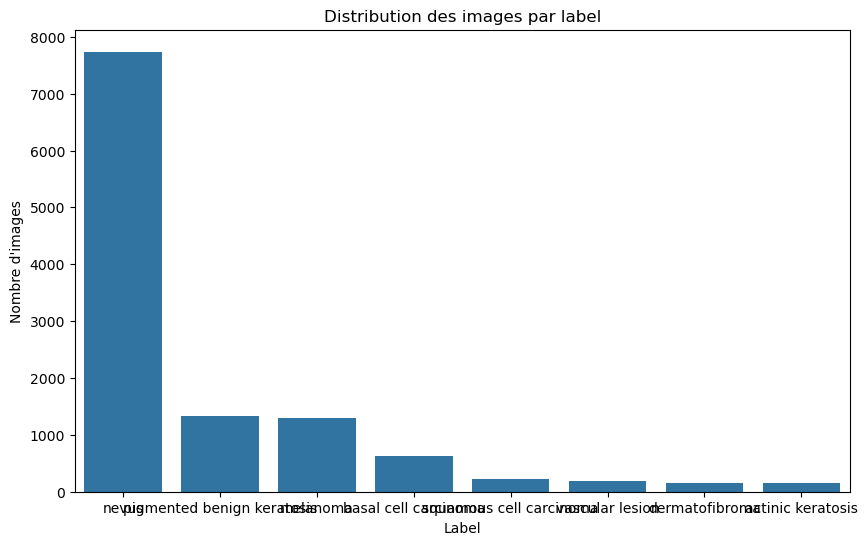

In [9]:
# Distribution des données
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution des images par label")
plt.xlabel("Label")
plt.ylabel("Nombre d'images")
plt.show()

In [10]:
# --- Step 3: Split the data ---
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['diagnosis'])


In [11]:
# --- Step 4: Data Augmentation ---
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_gen.flow_from_dataframe(
    dataframe=train_data,
    directory=image_dir,
    x_col='filename',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = data_gen.flow_from_dataframe(
    dataframe=test_data,
    directory=image_dir,
    x_col='filename',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 9376 validated image filenames belonging to 8 classes.
Found 2344 validated image filenames belonging to 8 classes.


In [12]:
# --- Step 5: Build the Model ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(len(label_counts), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
# --- Step 6: Train the Model with Checkpoints ---
base_dir = os.getcwd()  # Base directory
model_save_path = r"C:\\Users\\marti\\Desktop\\dom\\best_model.h5"  # Path to save the best model

# Callback to save the best checkpoints
checkpoint = ModelCheckpoint(
    model_save_path,  # Save the model at this path
    monitor='val_accuracy',  # Monitor validation accuracy for saving the best model
    save_best_only=True,  # Only save the model if it improves
    verbose=1  # Print updates when saving the model
)

# Train the model
history = model.fit(
    train_generator,  # Training data generator
    epochs=5,  # Number of epochs to train
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpoint]  # Use the checkpoint callback to save the best model during training
)

# Save the final model after training
final_model_path = r"C:\\Users\\marti\\Desktop\\dom\\final_model.h5"  # Path to save the final model
model.save(final_model_path)  # Save the final model
print(f"Final model saved at {final_model_path}")  # Print confirmation


Epoch 1/5
293/293 [==============================] - ETA: 0s - loss: 0.9100 - accuracy: 0.7136
Epoch 1: val_accuracy improved from -inf to 0.75811, saving model to c:\Users\marti\.vscode\extensions\danielsanmedium.dscodegpt-3.5.175\standalone\best_model.h5
293/293 [==============================] - 756s 3s/step - loss: 0.9100 - accuracy: 0.7136 - val_loss: 0.6680 - val_accuracy: 0.7581
Epoch 2/5
293/293 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.7596
Epoch 2: val_accuracy improved from 0.75811 to 0.77560, saving model to c:\Users\marti\.vscode\extensions\danielsanmedium.dscodegpt-3.5.175\standalone\best_model.h5
293/293 [==============================] - 679s 2s/step - loss: 0.6609 - accuracy: 0.7596 - val_loss: 0.6351 - val_accuracy: 0.7756
Epoch 3/5
293/293 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.7778
Epoch 3: val_accuracy improved from 0.77560 to 0.79138, saving model to c:\Users\marti\.vscode\extensions\danielsanmedium.ds

In [14]:
# --- Step 7: Evaluate the Model ---
print("\nEvaluating the model on test data...")
evaluation = model.evaluate(validation_generator)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


Evaluating the model on test data...
74/74 [==============================] - 125s 2s/step - loss: 0.6253 - accuracy: 0.7713
Test Loss: 0.6252527832984924, Test Accuracy: 0.7713310718536377


In [15]:
# --- Visualisation des courbes de pertes et de précision ---
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

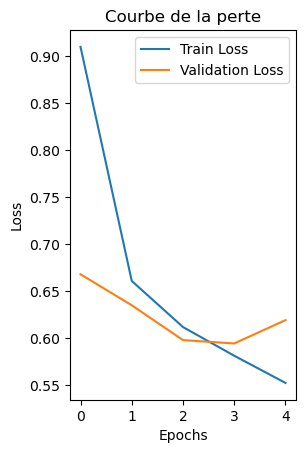

In [16]:
# Courbe de la perte
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Courbe de la perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

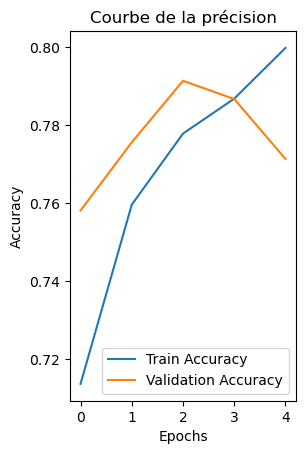

In [17]:
# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de la précision')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
# --- Step 8: Predictions and Metrics ---
print("\nGenerating predictions...")
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)


Generating predictions...
74/74 [==============================] - 127s 2s/step


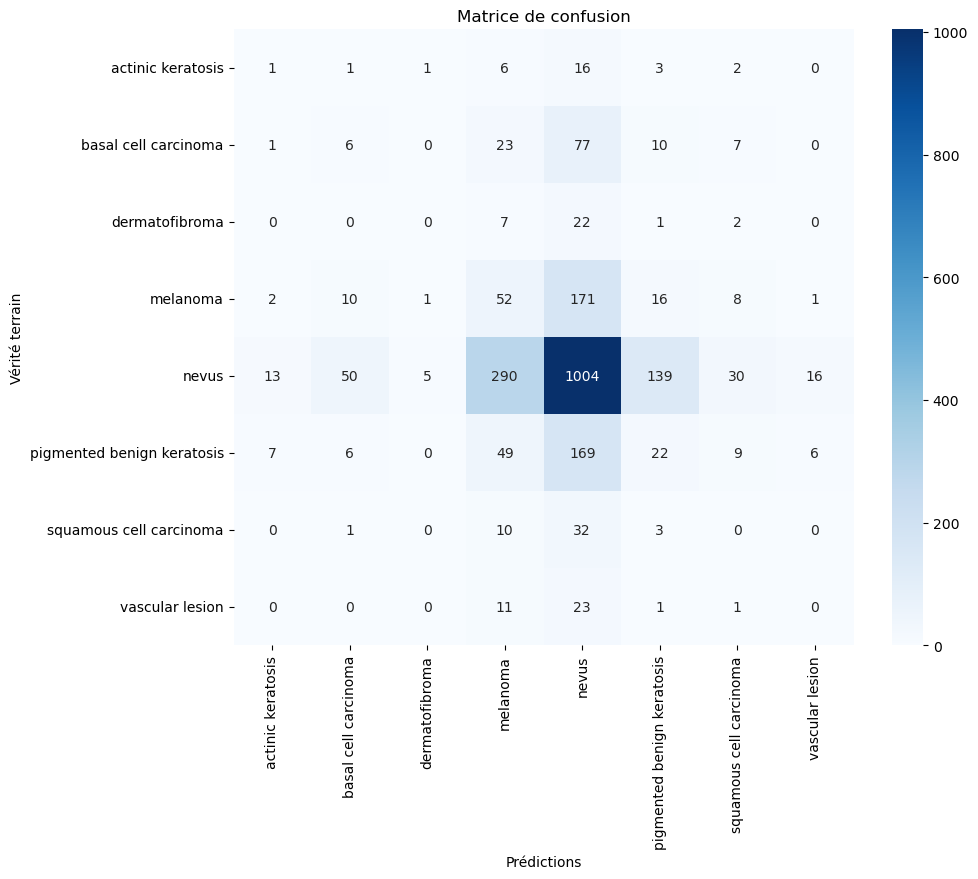

In [26]:
# Matrice de confusion graphique
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.show()


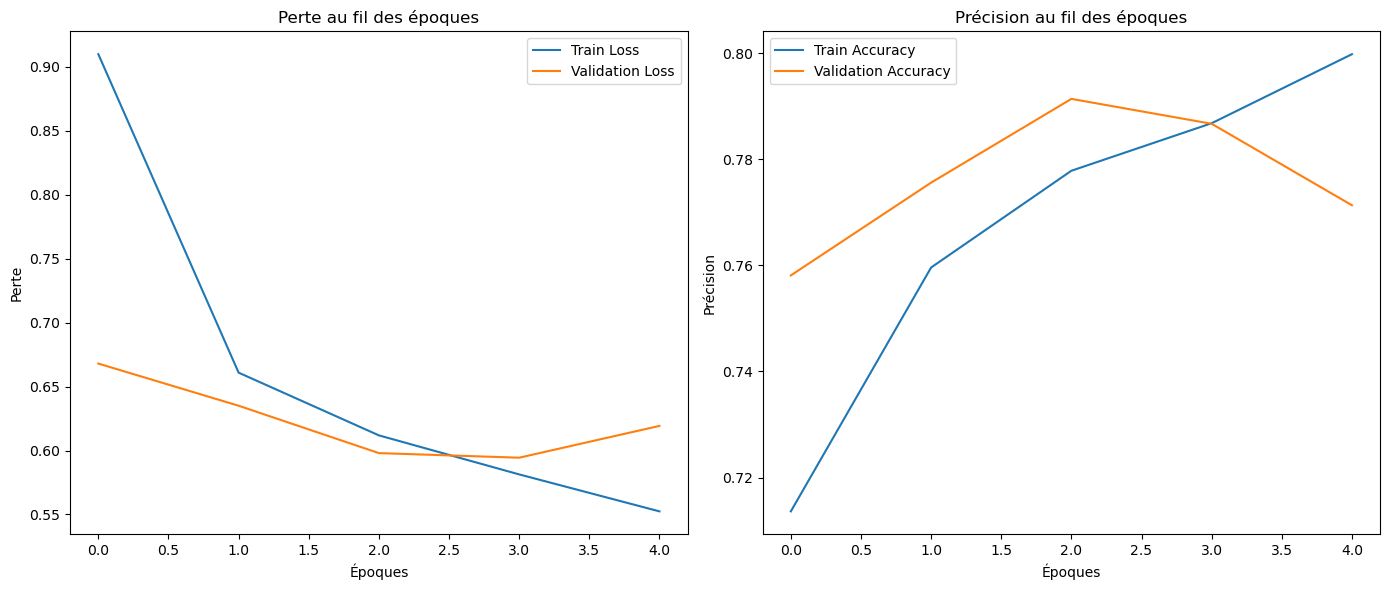

In [27]:
# Amélioration des courbes de performance
plt.figure(figsize=(14, 6))

# Courbe de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perte au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Précision au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.03      0.04        30
           1       0.08      0.05      0.06       124
           2       0.00      0.00      0.00        32
           3       0.12      0.20      0.15       261
           4       0.66      0.65      0.66      1547
           5       0.11      0.08      0.10       268
           6       0.00      0.00      0.00        46
           7       0.00      0.00      0.00        36

    accuracy                           0.46      2344
   macro avg       0.13      0.13      0.12      2344
weighted avg       0.47      0.46      0.46      2344



In [21]:
# ROC-AUC
if len(label_counts) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_true, y_pred_probs[:, 1])
    print("\nROC-AUC Score:", roc_auc)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Supposons que y_true et y_pred_probs soient déjà définis
# y_true = valeurs réelles de la variable cible
# y_pred_probs = probabilités des prédictions du modèle

if len(set(y_true)) == 2:  # Vérifier si c'est une classification binaire
    roc_auc = roc_auc_score(y_true, y_pred_probs[:, 1])
    print("\nROC-AUC Score:", roc_auc)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
    
    plt.figure(figsize=(8, 6))  # Taille de la figure
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("Il ne s'agit pas d'un problème de classification binaire.")


Il ne s'agit pas d'un problème de classification binaire.


In [22]:
# IoU (Intersection over Union)
def calculate_iou(cm):
    iou_per_class = {}
    for i, class_name in enumerate(validation_generator.class_indices):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-7)
        iou_per_class[class_name] = iou
    return iou_per_class

iou_scores = calculate_iou(cm)
print("\nIoU Scores per class:")
for class_name, iou in iou_scores.items():
    print(f"{class_name}: {iou:.2f}")


IoU Scores per class:
actinic keratosis: 0.02
basal cell carcinoma: 0.03
dermatofibroma: 0.00
melanoma: 0.08
nevus: 0.49
pigmented benign keratosis: 0.05
squamous cell carcinoma: 0.00
vascular lesion: 0.00


In [23]:
# --- Step 9: Use Focal Loss ---
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        weight = self.alpha * tf.math.pow(1 - y_pred, self.gamma)
        return tf.reduce_sum(weight * ce, axis=-1)

# Re-compile with Focal Loss
model.compile(
    optimizer='adam',
    loss=FocalLoss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

print("\nRecompiled the model with Focal Loss.")



Recompiled the model with Focal Loss.


1/1 [==============================] - 0s 90ms/step


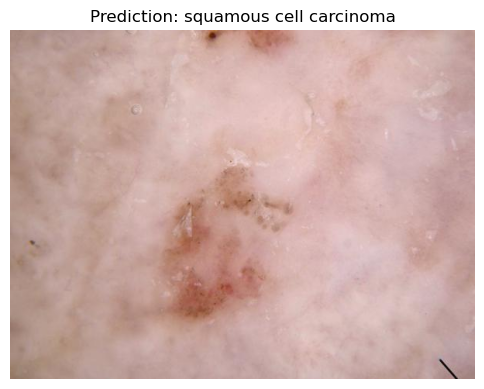

1/1 [==============================] - 0s 86ms/step


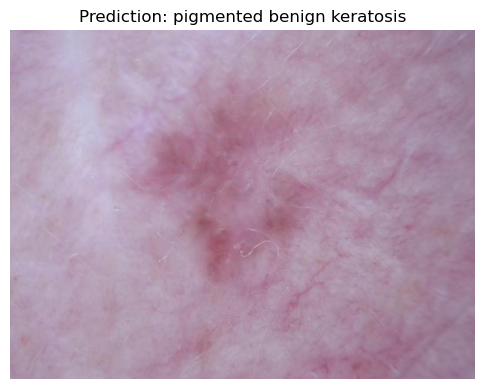

In [30]:
# --- Step 10: Test with New Images ---
def predict_on_new_images(model, image_paths, class_indices):
    """
    Prédit les classes des nouvelles images et affiche les résultats avec leurs étiquettes.
    
    Args:
        model: Le modèle pré-entraîné.
        image_paths: Liste des chemins des images à prédire.
        class_indices: Dictionnaire contenant les indices des classes.
    """
    from tensorflow.keras.preprocessing import image
    import matplotlib.pyplot as plt
    import os
    
    # Inverser le dictionnaire des indices des classes
    class_labels = {v: k for k, v in class_indices.items()}
    
    for img_path in image_paths:
        # Vérifiez si l'image existe
        if not os.path.exists(img_path):
            print(f"Image introuvable : {img_path}")
            continue
        
        # Charger l'image et la prétraiter
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Effectuer la prédiction
        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]
        
        # Afficher l'image et la prédiction
        plt.figure(figsize=(6, 6))
        plt.imshow(plt.imread(img_path))
        plt.title(f"Prediction: {predicted_class}")
        plt.axis('off')
        plt.show(block=True)  # S'assure que l'image s'affiche

# Exemple d'utilisation
image_paths = [
    r"C:\\Users\\marti\\Desktop\\dom\\Data\\ISIC_0024329.jpg",
    r"C:\\Users\\marti\\Desktop\\dom\\Data\\ISIC_0032991.jpg"
]
predict_on_new_images(model, image_paths, train_generator.class_indices)


In [24]:
# --- Step 10: Test with New Images ---
def predict_on_new_images(model, image_paths, class_indices):
    from tensorflow.keras.preprocessing import image
    class_labels = {v: k for k, v in class_indices.items()}
    
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]

        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}")
        plt.show()

In [25]:
# --- Step 11: Explainability with Grad-CAM ---
def generate_gradcam(model, img_path, layer_name):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.models import Model
    from tensorflow.keras import backend as K

    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    img = plt.imread(img_path)
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.title("Grad-CAM")
    plt.show()

1/1 [==============================] - 0s 98ms/step


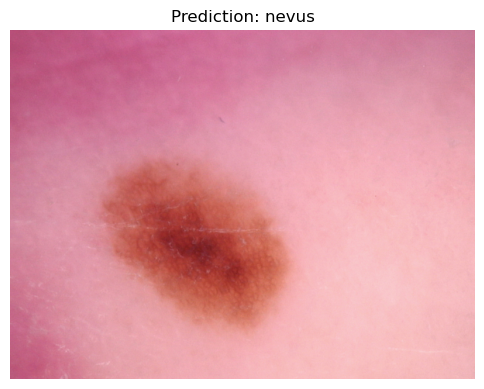

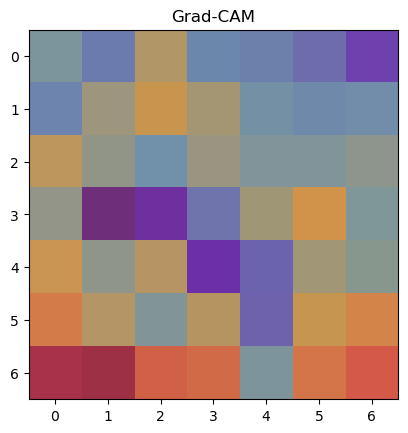

In [40]:
# --- Step 11: Explainability with Grad-CAM ---
def generate_gradcam(model, img_path, layer_name):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.models import Model
    from tensorflow.keras import backend as K

    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    img = plt.imread(img_path)
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.title("Grad-CAM")
    plt.show()

# Example Usage for Grad-CAM and Predictions
predict_on_new_images(
    model, 
    image_paths=[
        r"C:\\Users\\marti\\Desktop\\dom\\ISIC_0027380.jpg"
        
    ], 
    class_indices=train_generator.class_indices
)

generate_gradcam(
    model, 
    img_path=r"C:\\Users\\marti\\Desktop\\dom\\ISIC_0027380.jpg", 
    layer_name="conv5_block3_out"
)
